# Recommender- Yeah Money Money Money

### Requirements
```
python 3.6

numpy == '1.14.3'
pandas == '0.23.0'
tensorflow == '1.8.0'
keras == '2.2.0'
```
Other versions of above library will probably work

Prepare the csv data, from [movielens](https://grouplens.org/datasets/movielens/)

In [1]:
# %cd /data
# !!wget http://files.grouplens.org/datasets/movielens/ml-latest-small.zip
# !!unzip ml-latest-small.zip

In [4]:
import pandas as pd
import numpy as np
import os

In [3]:
DATA = "/data/ml-latest-small/"
DIM = 100 # dimension for embedding

In [5]:
files = os.listdir(DATA)
files

['links.csv', 'tags.csv', 'ratings.csv', 'README.txt', 'movies.csv']

In [6]:
data = dict()
for f in files:
    if f[-3:]=="csv":
        data[f.split(".")[0]] = pd.read_csv(DATA+f)

## Check Sample Data

In [7]:
from IPython.display import display
list(display(k,v.sample(5)) for k,v in data.items())

'links'

,movieId,imdbId,tmdbId
5528,8763,63389,64877.0
6604,50162,344854,9992.0
6895,58107,1023481,8328.0
4090,5357,110157,24767.0
7239,68967,836700,8282.0


'tags'

,userId,movieId,tag,timestamp
572,423,6713,Satoshi Kon,1354033681
1043,547,55276,toplist07,1195959915
1153,547,96728,toplist12,1355599008
1013,547,48394,holes00s,1342850387
1262,547,160954,bkk,1472178574


'ratings'

,userId,movieId,rating,timestamp
42649,306,1216,3.0,956081725
7262,44,135,4.0,858707310
74797,519,1240,4.5,1468758883
37768,271,2028,4.0,1107785352
9399,62,111759,4.0,1451708157


'movies'

,movieId,title,genres
7789,86320,Melancholia (2011),Drama|Sci-Fi
5742,26151,Au Hasard Balthazar (1966),Crime|Drama
7721,83613,Cowboys & Aliens (2011),Action|Sci-Fi|Thriller|Western|IMAX
7027,61236,Waltz with Bashir (Vals im Bashir) (2008),Animation|Documentary|Drama|War
7135,65193,Wild Child (2008),Drama|Romance


[None, None, None, None]

## Model On Rating

In [12]:
len(data["ratings"])

100004

In [13]:
userId = list(set(data["ratings"]["userId"]))
movieId = list(set(data["ratings"]["movieId"]))
print(len(userId),len(movieId))

671 9066


### Mapping
user to index, movie to index, index to user, index to movie

Use your own index for each appeared user, movie

In [20]:
u2i = dict((v,k) for k,v in enumerate(userId))
m2i = dict((v,k) for k,v in enumerate(movieId))
i2u = dict((k,v) for k,v in enumerate(userId))
i2m = dict((k,v) for k,v in enumerate(movieId))

In [21]:
data["ratings"]["movie_idx"] = data["ratings"]["movieId"].apply(lambda x:m2i[x])
data["ratings"]["user_idx"] = data["ratings"]["userId"].apply(lambda x:u2i[x])

Keras accepts array, so we turn pandas objects into array

In [48]:
user_array = data["ratings"]["user_idx"].values.reshape(-1,1)
movie_array = data["ratings"]["movie_idx"].values.reshape(-1,1)
rating_array = data["ratings"]["rating"].values.reshape(-1,1)/5

Check shapes on data

In [50]:
user_array.shape,movie_array.shape,rating_array.shape

((100004, 1), (100004, 1), (100004, 1))

## Model

In [ ]:
from keras.layers import *
from keras.models import *

In [253]:
def idx2vec(leng,name,dim = DIM):
    """
    leng: length of vector
    name: name the input layer
    dim: hidden dimension of embedding
    return: input tensor, embedding layer
    """
    ipt = Input((1,),name=name+"_ipt")
    ebd = Embedding(leng,dim)(ipt)
    ebd = SpatialDropout1D(.3)(ebd)
    return ipt,ebd

In [254]:
ipt_u, ebd_u = idx2vec(len(userId),"user")
ipt_m, ebd_m = idx2vec(len(movieId),"movie")

In [59]:
user2vec = Model(ipt_u,ebd_u)
movie2vec = Model(ipt_m,ebd_m)

### Check What's Embeding Layer

In [60]:
user2vec.predict(np.array([[0],[2]]))

array([[[ 1.91395916e-02, -4.51731198e-02,  4.37530987e-02,
         -1.63733847e-02,  6.41286373e-03,  4.66329344e-02,
         -2.11565029e-02, -3.47738862e-02,  2.13194229e-02,
          3.23534012e-03,  4.95511293e-03, -1.18402839e-02,
         -2.76263598e-02,  1.77213289e-02, -1.52823552e-02,
          2.01885365e-02,  3.57834809e-02, -1.48696899e-02,
          1.56355761e-02,  1.01965554e-02, -8.46663862e-03,
          3.66757549e-02,  3.48094441e-02, -2.57774722e-02,
          3.20844986e-02, -4.09193523e-02, -1.54222474e-02,
          2.47629397e-02,  4.87549193e-02, -4.60501797e-02,
         -8.87737423e-03, -3.97561304e-02, -1.64012089e-02,
         -4.16589901e-03,  4.20560725e-02, -4.36268337e-02,
          3.48217748e-02,  3.49102505e-02,  2.14034356e-02,
         -1.34521946e-02, -2.86731608e-02,  3.45314257e-02,
          4.00956757e-02, -2.78212875e-03, -3.91735211e-02,
         -2.87387371e-02, -3.99985909e-02,  3.78483795e-02,
         -2.96304822e-02, -1.71114132e-0

In [61]:
x = Multiply()([ebd_u,ebd_m])
x = Flatten()(x)
x = Dense(1,)(x)

cf = Model([ipt_u,ipt_m],x)

In [62]:
cf.compile("Adam",loss="mse",)

In [63]:
cf.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
user_ipt (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
movie_ipt (InputLayer)          (None, 1)            0                                            
__________________________________________________________________________________________________
embedding_5 (Embedding)         (None, 1, 100)       67100       user_ipt[0][0]                   
__________________________________________________________________________________________________
embedding_6 (Embedding)         (None, 1, 100)       906600      movie_ipt[0][0]                  
__________________________________________________________________________________________________
spatial_dr

In [64]:
cf.fit([user_array,movie_array],rating_array,epochs=5,shuffle=True,validation_split=.3,batch_size=512)

Train on 70002 samples, validate on 30002 samples
Epoch 1/5
70002/70002 [==============================] - 3s 40us/step - loss: 0.4550 - val_loss: 0.3848
Epoch 2/5
70002/70002 [==============================] - 2s 35us/step - loss: 0.2829 - val_loss: 0.2658
Epoch 3/5
70002/70002 [==============================] - 2s 35us/step - loss: 0.0808 - val_loss: 0.2275
Epoch 4/5
70002/70002 [==============================] - 2s 35us/step - loss: 0.0431 - val_loss: 0.2150
Epoch 5/5
70002/70002 [==============================] - 3s 37us/step - loss: 0.0334 - val_loss: 0.2082


### Deep Collaborative Filtering

In [260]:
ipt_u, ebd_u = idx2vec(len(userId),"user")
ipt_m, ebd_m = idx2vec(len(movieId),"movie")

x = Multiply()([ebd_u,ebd_m])
x = Flatten()(x)

# The rest is multi-layer perceptron
x = Dense(256,)(x)
x = BatchNormalization()(x)
x = Activation("relu")(x)
x = Dropout(.5)(x)
x = Dense(128,)(x)
x = BatchNormalization()(x)
x = Activation("relu")(x)
x = Dropout(.5)(x)
x = Dense(1,)(x)

In [261]:
cf_dnn = Model([ipt_u,ipt_m],x)

In [262]:
cf_dnn.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
user_ipt (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
movie_ipt (InputLayer)          (None, 1)            0                                            
__________________________________________________________________________________________________
embedding_31 (Embedding)        (None, 1, 100)       67100       user_ipt[0][0]                   
__________________________________________________________________________________________________
embedding_32 (Embedding)        (None, 1, 100)       906600      movie_ipt[0][0]                  
__________________________________________________________________________________________________
spatial_dr

In [263]:
cf_dnn.compile("Adam",loss="mse",)

In [264]:
cf_dnn.fit([user_array,movie_array],rating_array,epochs=3,shuffle=True,validation_split=.1,batch_size=512)

Train on 90003 samples, validate on 10001 samples
Epoch 1/3
90003/90003 [==============================] - 14s 150us/step - loss: 0.2071 - val_loss: 0.0628
Epoch 2/3
90003/90003 [==============================] - 12s 134us/step - loss: 0.0566 - val_loss: 0.0679
Epoch 3/3
90003/90003 [==============================] - 11s 127us/step - loss: 0.0499 - val_loss: 0.0908


### Visualization

In [265]:
cf_weights = cf_dnn.get_weights()

for w in cf_weights:
    print(w.shape)

(671, 100)
(9066, 100)
(100, 512)
(512,)
(512,)
(512,)
(512,)
(512,)
(512, 256)
(256,)
(256,)
(256,)
(256,)
(256,)
(256, 1)
(1,)


In [266]:
movie_vec = cf_weights[1]
movie_vec.shape

(9066, 100)

In [267]:
from sklearn.decomposition import PCA
# using principal component analysis to decompose the 100 dimensions
# compressing to 3 dimensions
pca = PCA(n_components=3,)

In [268]:
%time movie_3d = pca.fit_transform(movie_vec)

CPU times: user 73.3 ms, sys: 6.17 ms, total: 79.5 ms
Wall time: 41 ms


In [269]:
movie_3d

array([[-0.00768013,  0.01615258, -0.07155826],
       [-0.01850022,  0.04411795,  0.0232491 ],
       [ 0.03151993,  0.01458388,  0.04480629],
       ...,
       [-0.01081648, -0.03053492,  0.00942551],
       [ 0.01456629,  0.00669267, -0.01541577],
       [-0.05224302,  0.03019897, -0.01850397]], dtype=float32)

In [270]:
most_watched = pd.DataFrame(data["ratings"]["movieId"].value_counts())

In [271]:
most_watched = most_watched.reset_index().rename(columns={"index":"mid","movieId":"counts"})

In [272]:
mid2title = dict(zip(data["movies"]["movieId"],data["movies"]["title"]))
mid2genres = dict(zip(data["movies"]["movieId"],data["movies"]["genres"]))

In [273]:
mid2title

{1: 'Toy Story (1995)',
 2: 'Jumanji (1995)',
 3: 'Grumpier Old Men (1995)',
 4: 'Waiting to Exhale (1995)',
 5: 'Father of the Bride Part II (1995)',
 6: 'Heat (1995)',
 7: 'Sabrina (1995)',
 8: 'Tom and Huck (1995)',
 9: 'Sudden Death (1995)',
 10: 'GoldenEye (1995)',
 11: 'American President, The (1995)',
 12: 'Dracula: Dead and Loving It (1995)',
 13: 'Balto (1995)',
 14: 'Nixon (1995)',
 15: 'Cutthroat Island (1995)',
 16: 'Casino (1995)',
 17: 'Sense and Sensibility (1995)',
 18: 'Four Rooms (1995)',
 19: 'Ace Ventura: When Nature Calls (1995)',
 20: 'Money Train (1995)',
 21: 'Get Shorty (1995)',
 22: 'Copycat (1995)',
 23: 'Assassins (1995)',
 24: 'Powder (1995)',
 25: 'Leaving Las Vegas (1995)',
 26: 'Othello (1995)',
 27: 'Now and Then (1995)',
 28: 'Persuasion (1995)',
 29: 'City of Lost Children, The (Cité des enfants perdus, La) (1995)',
 30: 'Shanghai Triad (Yao a yao yao dao waipo qiao) (1995)',
 31: 'Dangerous Minds (1995)',
 32: 'Twelve Monkeys (a.k.a. 12 Monkeys) (199

In [274]:
most_watched["title"] = most_watched["mid"].apply(lambda x:mid2title[x])

In [275]:
most_watched.head(15)

,mid,counts,title
0,356,341,Forrest Gump (1994)
1,296,324,Pulp Fiction (1994)
2,318,311,"Shawshank Redemption, The (1994)"
3,593,304,"Silence of the Lambs, The (1991)"
4,260,291,Star Wars: Episode IV - A New Hope (1977)
5,480,274,Jurassic Park (1993)
6,2571,259,"Matrix, The (1999)"
7,1,247,Toy Story (1995)
8,527,244,Schindler's List (1993)
9,589,237,Terminator 2: Judgment Day (1991)


In [276]:
most_watched_ebd_idx = most_watched["mid"].apply(lambda x:m2i[x]).values

In [277]:
most_watched["vec_1"] = movie_3d[most_watched_ebd_idx][:,0]
most_watched["vec_2"] = movie_3d[most_watched_ebd_idx][:,1]
most_watched["vec_3"] = movie_3d[most_watched_ebd_idx][:,2]

In [278]:
most_watched.head(300).sort_values(by = "vec_1")

,mid,counts,title,vec_1,vec_2,vec_3
190,17,86,Sense and Sensibility (1995),-0.061856,0.010046,0.009240
228,2054,76,"Honey, I Shrunk the Kids (1989)",-0.061776,-0.005240,-0.008216
51,1036,151,Die Hard (1988),-0.059134,0.004523,0.030761
286,370,67,Naked Gun 33 1/3: The Final Insult (1994),-0.056403,-0.036555,-0.056147
2,318,311,"Shawshank Redemption, The (1994)",-0.054091,0.057730,0.021464
114,1259,112,Stand by Me (1986),-0.052279,0.016204,0.002403
221,2617,79,"Mummy, The (1999)",-0.051181,0.047107,0.004878
270,350,70,"Client, The (1994)",-0.049610,-0.051789,-0.000919
210,1207,80,To Kill a Mockingbird (1962),-0.049383,0.012758,-0.000763
139,2174,104,Beetlejuice (1988),-0.047993,0.010286,-0.016071


In [279]:
most_watched.head(300).sort_values(by = "vec_2")

,mid,counts,title,vec_1,vec_2,vec_3
149,1225,100,Amadeus (1984),-0.008892,-0.074089,-0.000843
95,58559,121,"Dark Knight, The (2008)",0.020311,-0.072027,0.014203
188,62,87,Mr. Holland's Opus (1995),-0.007185,-0.071931,0.019954
66,1221,135,"Godfather: Part II, The (1974)",0.011465,-0.068323,-0.003160
237,2700,75,"South Park: Bigger, Longer and Uncut (1999)",-0.016839,-0.060473,0.000655
1,296,324,Pulp Fiction (1994),-0.001501,-0.060103,0.030652
32,2028,191,Saving Private Ryan (1998),0.064985,-0.057575,-0.013271
224,509,78,"Piano, The (1993)",-0.010914,-0.053588,-0.004271
56,1291,147,Indiana Jones and the Last Crusade (1989),-0.035796,-0.052336,-0.059773
270,350,70,"Client, The (1994)",-0.049610,-0.051789,-0.000919


In [280]:
most_watched.head(300).sort_values(by = "vec_3")

,mid,counts,title,vec_1,vec_2,vec_3
96,2396,121,Shakespeare in Love (1998),-0.019043,0.025825,-0.082057
7,1,247,Toy Story (1995),-0.007680,0.016153,-0.071558
29,32,196,Twelve Monkeys (a.k.a. 12 Monkeys) (1995),-0.014221,0.033167,-0.062330
47,1240,158,"Terminator, The (1984)",0.043475,0.009335,-0.061458
56,1291,147,Indiana Jones and the Last Crusade (1989),-0.035796,-0.052336,-0.059773
37,595,176,Beauty and the Beast (1991),0.033926,-0.051664,-0.059280
202,1288,82,This Is Spinal Tap (1984),0.004016,-0.044450,-0.058142
244,1278,74,Young Frankenstein (1974),0.047931,0.009533,-0.056751
27,364,200,"Lion King, The (1994)",0.024618,-0.015100,-0.056477
286,370,67,Naked Gun 33 1/3: The Final Insult (1994),-0.056403,-0.036555,-0.056147


### Scatter Chart

In [281]:
from sklearn.decomposition import PCA
# using principal component analysis to decompose the 100 dimensions
# compressing to 3 dimensions
pca = PCA(n_components=2,)
%time movie_2d = pca.fit_transform(movie_vec)


CPU times: user 63.4 ms, sys: 4.29 ms, total: 67.7 ms
Wall time: 34.6 ms


In [282]:
most_watched["vec_1"] = movie_2d[most_watched_ebd_idx][:,0]
most_watched["vec_2"] = movie_2d[most_watched_ebd_idx][:,1]

In [283]:
from matplotlib import pyplot as plt
% matplotlib inline

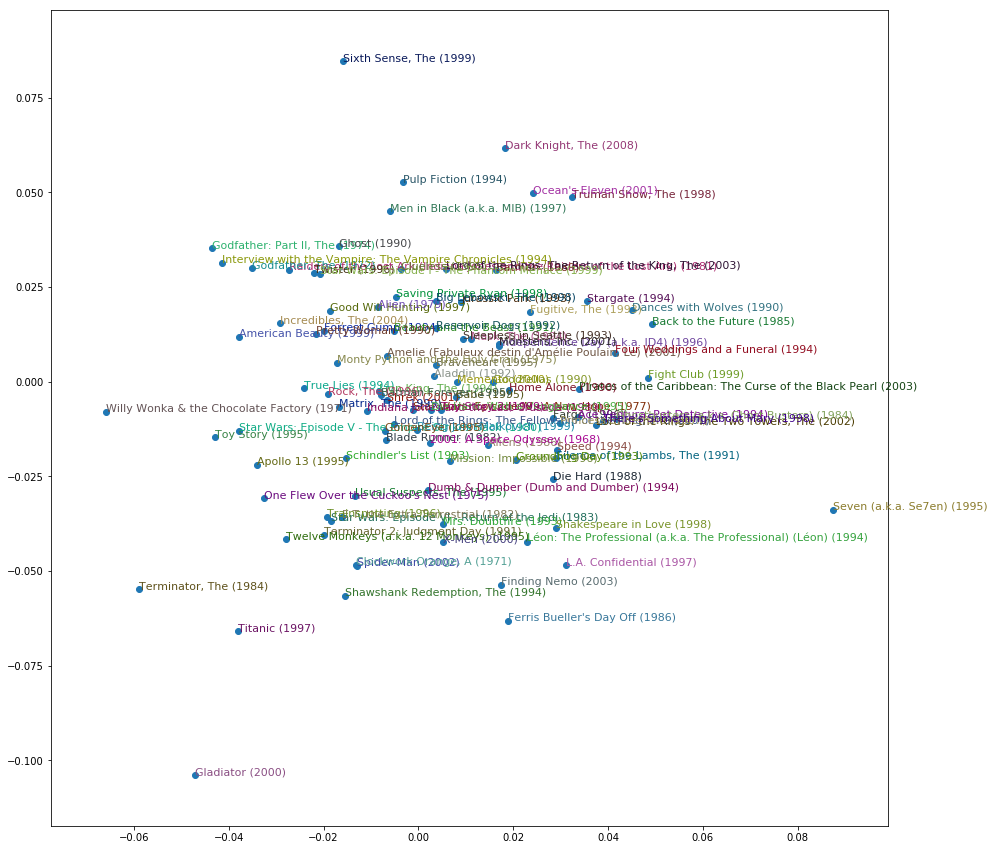

In [284]:
X = most_watched.head(100)["vec_1"]
Y = most_watched.head(100)["vec_2"]
plt.figure(figsize=(15,15))
plt.scatter(X, Y)
for i, x, y in zip(most_watched["title"], X, Y):
    plt.text(x,y,i, color=np.random.rand(3)*0.7, fontsize=11)
plt.show()

## Excercise

* Run through this notebook
* Try the [pytorch version here](experiments/collaborative_filtering_movie_lens.ipynb)
* Try the [20 million larger version of data](https://grouplens.org/datasets/movielens/)(about 20 million ratings rows)